In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [12]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

 75% 49.0M/65.2M [00:00<00:00, 56.9MB/s]
100% 65.2M/65.2M [00:00<00:00, 75.6MB/s]


In [13]:
import zipfile
zip_ref = zipfile.ZipFile('/content/emotion-detection-fer.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [46]:
train_df = tf.keras.utils.image_dataset_from_directory(
    '/content/train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 28709 files belonging to 7 classes.


In [47]:
import numpy as np

# Initialize an empty dictionary to store class counts
class_counts = {}

# Iterate over the batches in the dataset
for images, labels in train_df:
    # Convert labels tensor to numpy array
    labels_np = labels.numpy()

    # Count occurrences of each label
    unique_labels, counts = np.unique(labels_np, return_counts=True)

    # Update class_counts dictionary
    for label, count in zip(unique_labels, counts):
        if label not in class_counts:
            class_counts[label] = count
        else:
            class_counts[label] += count

# Print the class distribution
print("Class Distribution:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")


Class Distribution:
Class 0: 3995 samples
Class 2: 4097 samples
Class 3: 7215 samples
Class 4: 4965 samples
Class 5: 4830 samples
Class 6: 3171 samples
Class 1: 436 samples


In [48]:
class_names = train_df.class_names
print("Class Names:", class_names)

Class Names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


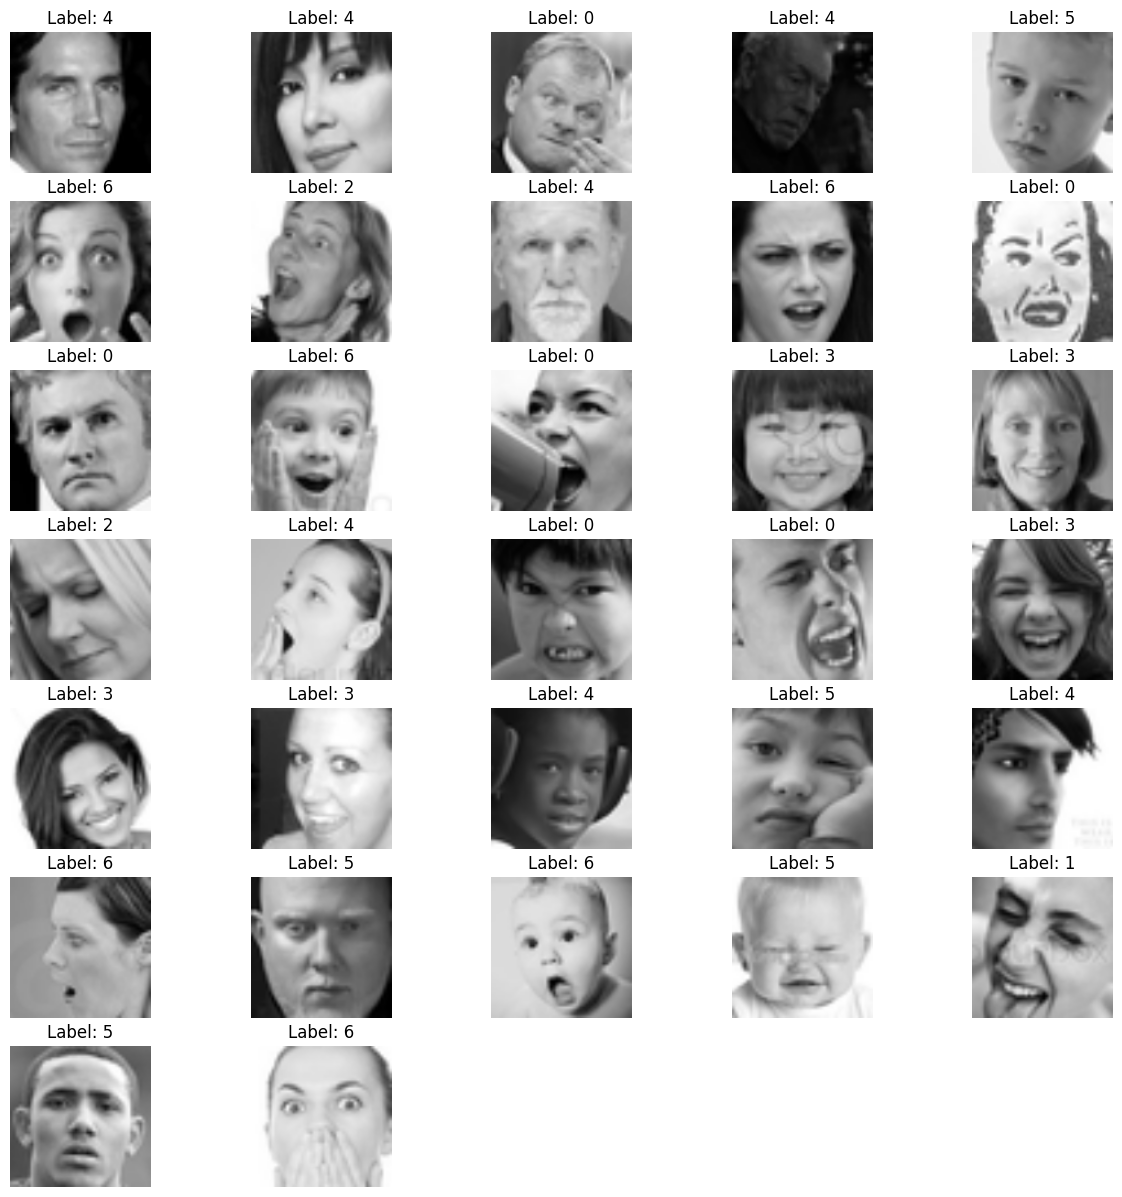

In [49]:
import matplotlib.pyplot as plt

# Iterate over the first batch of the dataset
for images, labels in train_df.take(1):
    plt.figure(figsize=(15, 15))
    batch_size = len(images)
    # Loop through each image and its corresponding label
    for i in range(batch_size):
        # Display the image and its label
        plt.subplot((batch_size // 5) + 1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()


In [50]:
test_df = tf.keras.utils.image_dataset_from_directory(
    '/content/test',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 7178 files belonging to 7 classes.


In [51]:
## normalize (np array is in range 0-255, bringing it within 0-1)
def process(image, label):
  image = tf.cast(image/255 , tf.float32)
  return image, label

train_df = train_df.map(process)
test_df = test_df.map(process)

In [52]:
# CNN model
model = Sequential()
model.add(Conv2D(128,kernel_size=(3,3), activation = 'relu' , input_shape = (128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256,kernel_size=(3,3), activation = 'relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512,kernel_size=(3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512,kernel_size=(3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(7,activation = 'softmax'))

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 128)     3584      
                                                                 
 batch_normalization_4 (Bat  (None, 126, 126, 128)     512       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 128)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 63, 63, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 256)       295168    
                                                                 
 batch_normalization_5 (Bat  (None, 61, 61, 256)      

In [54]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics =['accuracy'])

In [55]:
# Now you can fit the model
history = model.fit(train_df, epochs=20, validation_data=test_df)


Epoch 1/20
898/898 [==============================] - 154s 163ms/step - loss: 2.3151 - accuracy: 0.2354 - val_loss: 1.8057 - val_accuracy: 0.2575
Epoch 2/20
898/898 [==============================] - 146s 163ms/step - loss: 1.7008 - accuracy: 0.3141 - val_loss: 1.6916 - val_accuracy: 0.3233
Epoch 3/20
898/898 [==============================] - 138s 154ms/step - loss: 1.6005 - accuracy: 0.3614 - val_loss: 1.5776 - val_accuracy: 0.3693
Epoch 4/20
898/898 [==============================] - 137s 153ms/step - loss: 1.4967 - accuracy: 0.4082 - val_loss: 1.7501 - val_accuracy: 0.2934
Epoch 5/20
898/898 [==============================] - 137s 152ms/step - loss: 1.4355 - accuracy: 0.4370 - val_loss: 1.8050 - val_accuracy: 0.3312
Epoch 6/20
898/898 [==============================] - 138s 153ms/step - loss: 1.3842 - accuracy: 0.4660 - val_loss: 1.3266 - val_accuracy: 0.4657
Epoch 7/20
898/898 [==============================] - 137s 153ms/step - loss: 1.3562 - accuracy: 0.4825 - val_loss: 2.7511 -

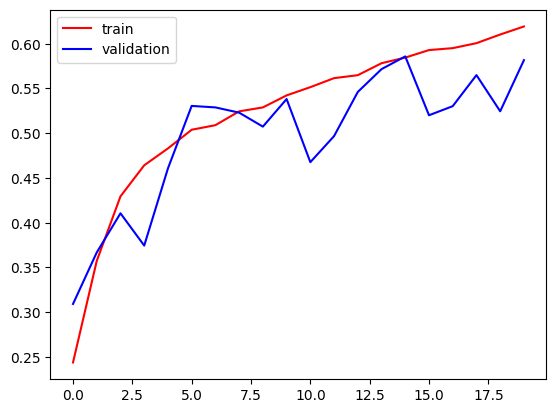

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color ='red',label ='train')
plt.plot(history.history['val_accuracy'],color ='blue', label ='validation')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the image and preprocess it
img_path = 'file.jpg'
target_size = (224, 224)  # Set the target size for displaying the image
model_input_size = (128, 128)  # Set the input size for the model
img = image.load_img(img_path, target_size=target_size)  # Load the image with larger target size
img_array = image.img_to_array(img)
img_array = image.smart_resize(img_array, model_input_size)  # Resize the image to model input size
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image

# Make prediction
prediction = model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(prediction)

# Define class names
class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise", ]

# Print the predicted class
print("Predicted Emotion Class:", class_names[predicted_class])

# Display the image
plt.imshow(img)
plt.title("Predicted Emotion: " + class_names[predicted_class])
plt.axis("off")
plt.show()


In [57]:
model.save('emotionsyes_model.h5')